In [1]:
# noinspection PyUnresolvedReferences

# noinspection PyUnresolvedReferences
import functools
# noinspection PyUnresolvedReferences
import functools
import json
import os

# noinspection PyUnresolvedReferences
import IPython
# noinspection PyUnresolvedReferences
import ipywidgets as widgets
# noinspection PyUnresolvedReferences
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
import numpy as np
# noinspection PyUnresolvedReferences
from IPython.display import display, Latex
# noinspection PyUnresolvedReferences
from lmfit import Model
# noinspection PyUnresolvedReferences
from matplotlib.gridspec import GridSpec
# noinspection PyUnresolvedReferences
from matplotlib.patches import Circle

# noinspection PyUnresolvedReferences
from analyzer import Analyzer
# noinspection PyUnresolvedReferences
from diffusion_PDEs import SigmoidDiffusivityPDE, LogisticDiffusionPDE, LinearDiffusivityPDE
# noinspection PyUnresolvedReferences
from diffusion_array import DiffusionArray
# noinspection PyUnresolvedReferences
from homogenizer import Homogenizer
# noinspection PyUnresolvedReferences
from pde_solver import SymmetricIVPPDESolver
# noinspection PyUnresolvedReferences
from step_widget import PipeLineWidget, ClippingWidget, StartFrameWidget, StartPlaceWidget, BackgroundRemovalWidget, \
    NormalizingWidget

# --- END OF IMPORTS ---

directory_paths = [r'G:\rost\Ca2+_laser\raw_data', r'G:\rost\kozep\raw_data', r'G:\rost\sarok\raw_data']
file_paths = []

for directory in directory_paths:
    for root, _, files in os.walk(directory):
        file_paths.extend([os.path.join(root, file) for file in files if file.endswith('.nd2')])

alias_to_file = dict()
with open('../config.json', 'r') as json_file:
    config_file = json.load(json_file)

for file_path in file_paths:
    alias_to_file[config_file[os.path.basename(file_path)]['alias']] = file_path

# --- END OF ND2-FINDING

selected = 'ATP-kozep-018'
original_darr = None
selected_channel = None
loading_message = widgets.Label(value='')
file_selector = widgets.Dropdown(
    description='Select a file',
    options=alias_to_file.keys(),
    value=selected
)


def on_selected_file_change(__change=None):
    global original_darr, selected
    outer.clear_output(wait=True)
    loading_message.value = f'Started loading: {file_selector.value}'
    original_darr = DiffusionArray(alias_to_file[file_selector.value])
    loading_message.value = f'{file_selector.value} is loaded'
    selected = file_selector.value
    on_darr_change()


outer = widgets.Output()


def on_darr_change(__change=None):
    frames = original_darr.number_of_frames - 2
    channels = original_darr.number_of_channels - 1
    frame_slider = widgets.IntSlider(value=8, min=0, max=frames, description='Frame:')
    channel_combobox = widgets.Dropdown(options=range(channels + 1), description='Channel:')
    output = widgets.Output()

    max_v = np.percentile(original_darr, q=99.5)
    min_v = np.percentile(original_darr, q=0.5)

    def on_change(__change=None):
        output.clear_output(wait=True)

        global original_darr, selected_channel
        original_darr = original_darr.channel(channel_combobox.value)
        selected_channel = channel_combobox.value

        with output:
            plt.clf()
            plt.imshow(original_darr.frame(frame_slider.value).channel(channel_combobox.value), vmin=min_v, vmax=max_v)
            plt.show()

    frame_slider.observe(on_change, names='value')
    channel_combobox.observe(on_change, names='value')

    with outer:
        display(frame_slider, channel_combobox, output)

    on_change()


file_selector.observe(on_selected_file_change, names='value')
display(loading_message, file_selector, outer)

on_selected_file_change()

Label(value='')

Dropdown(description='Select a file', index=5, options=('Ca2-sarok-006', 'Ca2-sarok-007', 'Ca2-sarok-008', 'AT…

Output()

In [2]:
darr, start_frame, start_place, min_v, max_v = None, None, None, None, None

outer = widgets.Output()


def on_transformed_darr_change(__change=None):
    frames = darr.number_of_frames - 2
    frame_slider = widgets.IntSlider(value=start_frame, min=0, max=frames, description='Frame:')
    output = widgets.Output()

    def on_change(__change=None):
        output.clear_output(wait=True)
        with output:
            plt.clf()
            plt.imshow(darr.frame(frame_slider.value), vmin=min_v, vmax=max_v)
            plt.show()

    frame_slider.observe(on_change, names='value')

    with outer:
        display(frame_slider, output)
    on_change()


def save_pipline_results(results):
    global darr, start_frame, start_place, min_v, max_v
    darr = results[0]
    start_frame = results[1]
    start_place = results[2]
    min_v = np.min(darr)
    max_v = np.max(darr)
    on_transformed_darr_change()


pipeline = PipeLineWidget(original_darr, apply_callback=save_pipline_results)

display(pipeline, loading_message, outer)
pipeline.add_step(ClippingWidget())
pipeline.add_step(StartFrameWidget())
pipeline.add_step(StartPlaceWidget())
pipeline.add_step(BackgroundRemovalWidget())
pipeline.add_step(NormalizingWidget())

save_pipline_results(pipeline.apply_pipeline())

HTML(value='<style>:root {\n    --light-gary-color: #ececed;\n    --green-color: #5ab23c;\n    --red-color: #d…

PipeLineWidget()

Label(value='ATP-kozep-018 is loaded')

Output()

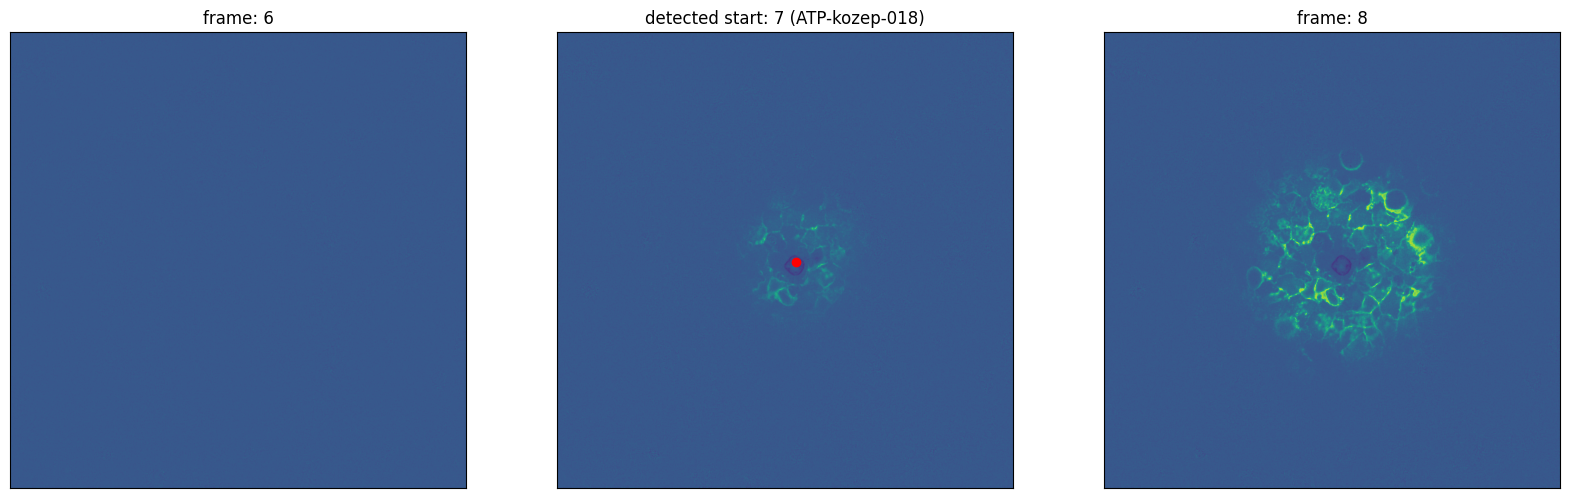

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for ax in axes: ax.tick_params(label1On=False, tick1On=False)

axes[0].imshow(darr.frame(start_frame - 1), vmin=min_v, vmax=max_v)
axes[0].set_title(f'frame: {start_frame - 1}')
axes[1].imshow(darr.frame(start_frame), vmin=min_v, vmax=max_v)
axes[1].set_title(f'detected start: {start_frame} ({selected})')
axes[1].scatter(*start_place, color='red')
axes[2].imshow(darr.frame(start_frame + 1), vmin=min_v, vmax=max_v)
axes[2].set_title(f'frame: {start_frame + 1}')

plt.show()

In [6]:
names_to_aggregator_functions = {
    'mean': np.mean,
    'median': np.median,
    'sum': np.sum,
    '99th percentile': functools.partial(np.percentile, q=99),
    '1st percentile': functools.partial(np.percentile, q=1),
    'max': np.max,
    'min': np.min,
}

aggregator_selector_widget = widgets.Dropdown(
    options=names_to_aggregator_functions.keys(),
    value=list(names_to_aggregator_functions.keys())[0],
)
normalize_after_agg_widget = widgets.Checkbox(True)
other_files = widgets.VBox()
output = widgets.Output()
loading_message = widgets.Label(value='')

alias_to_aggregate = {}


def on_change(__change=None):
    output.clear_output(wait=True)

    with output:
        aggregates_by_frame = Analyzer(darr).apply_for_each_frame(
            function=names_to_aggregator_functions[aggregator_selector_widget.value],
            normalize=normalize_after_agg_widget.value
        )
        plt.clf()
        loading_message.value = f'processing {selected}'

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        # plt.figure(dpi=300)
        axes[0].plot(aggregates_by_frame)
        axes[0].set_xlabel('frame')
        axes[0].set_ylabel('intensity')
        axes[0].set_title(f'{aggregator_selector_widget.value} of intensities by frame ({selected})')

        selected_aliases = [ch.description for ch in other_files.children if ch.value]

        if len(selected_aliases) == 0:
            argmax = np.argmax(aggregates_by_frame)
            axes[1].imshow(darr.frame(argmax))
            axes[1].set_title(f'the {argmax}th frame')
        else:
            for alias in selected_aliases:
                loading_message.value = f'processing {alias}'
                if key := (alias, aggregator_selector_widget.value,
                           normalize_after_agg_widget.value) in alias_to_aggregate:
                    aggregates_by_frame = alias_to_aggregate[key]
                else:
                    aggregates_by_frame = Analyzer(
                        pipeline.apply_pipeline(DiffusionArray(alias_to_file[alias]).channel(selected_channel))[0]
                    ).apply_for_each_frame(
                        function=names_to_aggregator_functions[aggregator_selector_widget.value],
                        normalize=normalize_after_agg_widget.value
                    )
                    alias_to_aggregate[key] = aggregates_by_frame

                axes[1].plot(aggregates_by_frame, label=alias)
                axes[1].set_xlabel('frame')
                axes[1].set_ylabel('intensity')
                axes[1].legend()
        loading_message.value = ''
        plt.show()


ch = []
for alias in alias_to_file.keys():
    checkbox = widgets.Checkbox(description=alias)
    checkbox.observe(on_change, names='value')
    ch.append(checkbox)
other_files.children = ch

normalize_after_agg_widget.observe(on_change, names='value')
aggregator_selector_widget.observe(on_change, names='value')

display(
    widgets.HBox([widgets.Label('Aggregator function:'), aggregator_selector_widget]),
    widgets.HBox([widgets.Label('Normalize after aggregation ?'), normalize_after_agg_widget]),
    widgets.HBox([widgets.Label('Select other files to compare:'), other_files]),
    loading_message,
    output
)
on_change()

Label(value='')

Output()

In [12]:
names_to_aggregator_functions = {
    'mean': np.mean,
    'median': np.median,
    'sum': np.sum,
    '99th percentile': functools.partial(np.percentile, q=99),
    '1st percentile': functools.partial(np.percentile, q=1),
    'max': np.max,
    'min': np.min,
}

aggregator_selector_widget = widgets.Dropdown(
    options=names_to_aggregator_functions.keys(),
    value=list(names_to_aggregator_functions.keys())[0],
)
normalize_after_agg_widget = widgets.Checkbox(False)
add_average_before_start = widgets.Checkbox(True)
average_before_start = 0
decay_function_widget = widgets.Dropdown(
    options=['exponential decay', 'logistic decay'],
    value='logistic decay'
)
output = widgets.Output()


def exponential_decay(x, a, b):
    return a * np.exp(-b * x) + average_before_start


def logistic_decay(x, mu, c, ):
    p = c / mu * (1 - np.exp(-mu * x))
    p[x > frame_of_max_intensity] = (c / mu * (1 - np.exp(-mu * frame_of_max_intensity))) * np.exp(
        -mu * (x[x > frame_of_max_intensity] - frame_of_max_intensity))
    return p + average_before_start


def on_change(__change=None):
    output.clear_output(wait=True)

    with output:
        plt.clf()
        global frame_of_max_intensity

        aggregates_by_frame = Analyzer(darr).apply_for_each_frame(
            function=names_to_aggregator_functions[aggregator_selector_widget.value],
            normalize=normalize_after_agg_widget.value
        )

        global average_before_start
        if add_average_before_start.value == True:
            average_before_start = np.mean(aggregates_by_frame[:start_frame - 1])
        else:
            average_before_start = 0

        if decay_function_widget.value == 'exponential decay':
            frame_of_max_intensity = np.argmax(aggregates_by_frame)
            display(IPython.display.Latex(r'$a e^{-b x}$'))
            model = Model(exponential_decay)
            y = aggregates_by_frame[frame_of_max_intensity:]
            x = np.arange(len(y)) + frame_of_max_intensity
            params = model.make_params(
                a=dict(value=np.mean(y), min=-5),
                b=dict(value=0.05, min=-5)
            )

            result = model.fit(y, params, x=x)
            plt.plot(x, result.best_fit, 'r-')


        elif decay_function_widget.value == 'logistic decay':
            frame_of_max_intensity = np.argmax(aggregates_by_frame) - start_frame + 1
            display(IPython.display.Latex(
                r'$f(t) = \begin{cases}'
                r'\frac{c}{\mu} (1 - e^{-\mu t}) & \text{if } t \leq T^*, \\'
                r'\frac{c}{\mu} (1 - e^{-\mu T^*}) e^{-\mu (t - T^*)} & \text{otherwise.}'
                r'\end{cases}$'
            ))
            model = Model(logistic_decay)
            y = aggregates_by_frame[start_frame - 1:]
            x = np.arange(len(y))
            params = model.make_params(
                c=dict(value=np.mean(y), min=-5),
                mu=dict(value=0.05, min=-5),
                # argmax=dict(value=3, min=0, max=len(y) - 1),
            )

            result = model.fit(y, params, x=x)
            plt.plot(x + start_frame - 1, result.best_fit, 'r-')

        for param in params:
            print(f'{param:}={result.params[param].value: .4f}')

        print(f'\nr squared: {result.rsquared: .4f}')
        print(f'mse: {np.mean((result.best_fit - y) ** 2): .4f}')
        # print(result.best_values)

        plt.plot(range(len(aggregates_by_frame)), aggregates_by_frame, 'bo')
        plt.xlabel('frame')
        plt.ylabel('intensity')
        plt.title(f'{aggregator_selector_widget.value} of intensities by frame ({selected})')
        plt.show()


normalize_after_agg_widget.observe(on_change, names='value')
aggregator_selector_widget.observe(on_change, names='value')
decay_function_widget.observe(on_change, names='value')
add_average_before_start.observe(on_change, names='value')

display(
    widgets.HBox([widgets.Label('aggregator function:'), aggregator_selector_widget]),
    widgets.HBox([widgets.Label('normalize after aggregation ?'), normalize_after_agg_widget]),
    widgets.HBox([widgets.Label('add average before start ?'), add_average_before_start]),
    widgets.HBox([widgets.Label('decay function:'), decay_function_widget]),
    output
)
on_change()

Output()

In [10]:
frames = darr.number_of_frames - 2
frame_slider = widgets.IntSlider(value=start_frame, min=0, max=frames, description='Frame: ')
colormap_checkbox = widgets.Checkbox(description='Use same colormap for homogenized?', value=False)
start_place_checkbox = widgets.Checkbox(description='Show start place?', value=True)
front_speed_checkbox = widgets.Checkbox(description='Show front speed?', value=True)
front_extent_checkbox = widgets.Checkbox(description='Show front extend?', value=True)
aggregator_selector_widget = widgets.Dropdown(options=['mean', 'median'], value='median')
output = widgets.Output()

names_to_aggregator_functions = {'mean': np.mean, 'median': np.median}
rtp = Homogenizer.Builder().start_frame(start_frame).center_point(start_place) \
    .aggregating_function(
    functools.partial(names_to_aggregator_functions[aggregator_selector_widget.value], axis=1)).with_delta_r(1) \
    .build().homogenize(darr)

resized_rtp = rtp.resized(rtp.width, 1)

homm = rtp.to_diffusion_array(1)


def on_change(__change=None):
    min_c = min_v if colormap_checkbox.value else np.min(rtp)
    max_c = max_v if colormap_checkbox.value else np.max(rtp)
    frame = frame_slider.value

    output.clear_output(wait=True)
    with output:
        try:
            plt.clf()
            fig = plt.figure(figsize=(8, 8))
            gs = GridSpec(2, 2)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.imshow(darr.frame(frame), vmin=min_v, vmax=max_v)
            ax1.set_xlim(0, darr.width)
            ax1.set_ylabel(selected)
            ax1.set_ylim(darr.height, 0)
            if start_place_checkbox.value: ax1.scatter(*start_place, color='red')
            ax1.tick_params(label1On=False, tick1On=False)

            ax2 = fig.add_subplot(gs[0, 1])
            ax2.imshow(homm.frame(frame), vmin=min_c, vmax=max_c)
            ax2.set_xlim(0, homm.width)
            ax2.set_ylim(homm.height, 0)
            if start_place_checkbox.value: ax2.scatter(*start_place, color='red')
            ax2.tick_params(label1On=False, tick1On=False)

            ax3 = fig.add_subplot(gs[1, :])
            ax3.imshow(np.array(rtp).T, aspect='auto', vmin=min_c, vmax=max_c)
            ax3.invert_yaxis()
            ax3.set_ylabel('Distance from origin')
            ax3.set_xlabel('Frame')
            ax3.set_ylim(0, rtp.width)
            ax3.axvline(x=frame, color='red', linestyle='--', linewidth=1)

            np_array_rtp__t = np.array(rtp).T[10:-10]

            # background = np.max(np_array_rtp__t[:, :start_frame])
            background = max(np.mean(np_array_rtp__t[:, start_frame - 5:start_frame + 3]),
                             np.max(np_array_rtp__t[:, :start_frame]))

            np_array_rtp__t[np_array_rtp__t > background] = 1
            # ax3.imshow(np_array_rtp__t, aspect='auto')

            cols, rows = np.where(np_array_rtp__t > background)
            rows = rows.astype(np.int32)
            cols = cols.astype(np.int32)

            occupied_cols = [False] * rtp.number_of_frames
            selected_rows = []
            selected_cols = []

            for row, col in sorted(zip(rows, cols), reverse=True):
                if occupied_cols[row]:
                    continue

                selected_rows.append(row)
                selected_cols.append(col)
                occupied_cols[row] = True

            cords = list()

            highest = 0
            for row, col in sorted(zip(selected_rows, selected_cols), key=lambda tup: tup[1]):
                cords.append((row, col + 10))

            cords = list(sorted(cords))
            red_cords = {cords[0]}
            highest = 0
            for i in range(1, len(cords) - 1):
                prev = cords[i - 1]
                this = cords[i]
                next = cords[i + 1]
                if prev[1] < this[1] and next[1] < this[1]:
                    this = (this[0], (prev[1] + next[1]) / 2)

                if this[1] >= highest and this[1] <= np_array_rtp__t.shape[0] - 10:
                    red_cords.add(this)

                highest = max(highest, this[1])
                cords[i] = this

            first_x = min(x for x, y in set(cords) - red_cords)
            true_red = []
            for row, col in cords:
                color = 'orange'
                if (row, col) in red_cords and row < first_x:
                    color = 'red'
                    true_red.append((row, col))

                if front_extent_checkbox.value:
                    ax3.scatter(row, col, color=color)
                    if row == frame:
                        circle1 = Circle(start_place, col, edgecolor=color, facecolor='none')
                        circle2 = Circle(start_place, col, edgecolor=color, facecolor='none')

                        ax2.add_patch(circle1)
                        ax1.add_patch(circle2)

            def line(x, m, b):
                return m * x + b

            red_cords = list(sorted(true_red, key=lambda tup: tup[0]))
            model = Model(line)
            params = model.make_params(m=1, b=0)
            result = model.fit([cord[1] for cord in red_cords], params, x=[cord[0] for cord in red_cords])

            for param in params:
                print(f'{param:} = {result.params[param].value: .4f}')

            print(f'\nr squared = {result.rsquared: .4f}')

            if front_speed_checkbox.value:
                ax3.plot(
                    [cord[0] for cord in red_cords],
                    result.best_fit,
                    color='lime'
                )

            gs.tight_layout(fig)
            plt.show()
        except Exception as e:
            print(e)


def on_aggregator_change(__change=None):
    global rtp

    rtp = Homogenizer.Builder().start_frame(start_frame).center_point(start_place) \
        .aggregating_function(
        functools.partial(names_to_aggregator_functions[aggregator_selector_widget.value], axis=1)).with_delta_r(1) \
        .build().homogenize(darr)

    on_change()


aggregator_selector_widget.observe(on_aggregator_change, names='value')
frame_slider.observe(on_change, names='value')
colormap_checkbox.observe(on_change, names='value')
start_place_checkbox.observe(on_change, names='value')
front_extent_checkbox.observe(on_change, names='value')
front_speed_checkbox.observe(on_change, names='value')

display(aggregator_selector_widget, frame_slider, colormap_checkbox, start_place_checkbox, front_extent_checkbox,
        front_speed_checkbox, output)
on_change()

Dropdown(index=1, options=('mean', 'median'), value='median')

IntSlider(value=7, description='Frame: ', max=41)

Checkbox(value=False, description='Use same colormap for homogenized?')

Checkbox(value=True, description='Show start place?')

Checkbox(value=True, description='Show front extend?')

Checkbox(value=True, description='Show front speed?')

Output()

In [11]:
frame_slider = widgets.IntSlider(value=start_frame, min=0, max=rtp.number_of_frames - 1, description='Frame:')
support_points_slider = widgets.IntSlider(value=rtp.width, min=40, max=rtp.width, description='Support points:')
show_average = widgets.Checkbox(description='Show average?')
output = widgets.Output()


def on_change(__change=None):
    global resized_rtp
    resized_rtp = rtp.resized(support_points_slider.value, 1)

    inner_radius = resized_rtp.width
    mean = np.mean(resized_rtp.frame(start_frame - 1))
    for f in range(start_frame, resized_rtp.number_of_frames - 1):
        for r in range(np.argmax(resized_rtp.frame(f)), -1, -1):
            if resized_rtp.frame(f)[r] >= mean >= resized_rtp.frame(f)[r - 1]:
                inner_radius = min(inner_radius, r)
                break

    output.clear_output(wait=True)
    with output:
        plt.plot(np.arange(inner_radius, resized_rtp.width), resized_rtp.frame(frame_slider.value)[inner_radius:])
        plt.plot(np.arange(0, inner_radius + 1), resized_rtp.frame(frame_slider.value)[:inner_radius + 1], color='grey')
        plt.xlabel('Intensity')
        plt.ylabel('Resized distance from origin')
        plt.ylim(0.98 * np.min(resized_rtp), 1.02 * np.max(resized_rtp))

        if show_average.value:
            plt.axhline(y=mean, color='lime', linestyle='--')
        plt.title(f'RTP cutoff ({selected})')
        plt.show()


frame_slider.observe(on_change, 'value')
support_points_slider.observe(on_change, 'value')
show_average.observe(on_change, 'value')

display(frame_slider, support_points_slider, show_average, output)
on_change()

IntSlider(value=7, description='Frame:', max=41)

IntSlider(value=749, description='Support points:', max=749, min=40)

Checkbox(value=False, description='Show average?')

Output()

In [ ]:
pde_combobox = widgets.Dropdown(value='Linear diffusion',
                                options=['Linear diffusion', 'Logistic diffusion', 'Sigmoid diffusion'])

diffusivity_float_text = widgets.FloatText(description='D:')
mu_float_text = widgets.FloatText(description='μ:')
alpha_float_text = widgets.FloatText(description='α:')
beta_float_text = widgets.FloatText(description='β:')
lambda_term_float_text = widgets.FloatText(description='λ:')

solve_button = widgets.Button(description='Solve equation')

frame_slider = widgets.IntSlider(value=0, min=0, max=rtp.number_of_frames - 1, description='Frame:')

output_select = widgets.Output()

names_to_latex = {
    'Linear diffusion': r'$\partial_t c = D \cdot \nabla^2 c - \mu c$',
    'Sigmoid diffusion': r'$\partial_t c = \frac{1}{1 + e^{\beta - D  c}} \nabla^2 c - \mu c$',
    'Logistic diffusion': r'$\partial_t c = D \cdot \nabla^2 c + \alpha c \cdot (\lambda - c)$'
}

names_to_pdes = {
    'Linear diffusion': LinearDiffusivityPDE,
    'Logistic diffusion': LogisticDiffusionPDE,
    'Sigmoid diffusion': SigmoidDiffusivityPDE,
}

names_to_params = {
    'Linear diffusion': [('diffusivity', diffusivity_float_text), ('mu', mu_float_text)],
    'Logistic diffusion': [('diffusivity', diffusivity_float_text), ('lambda_term', lambda_term_float_text),
                           ('alpha', alpha_float_text)],
    'Sigmoid diffusion': [('diffusivity', diffusivity_float_text), ('mu', mu_float_text), ('beta', beta_float_text)],
}

user_interaction = True
pde = None
frame_of_max_intensity = None
sol = None
inner_radius = None


def on_pde_change(__change=None):
    global user_interaction
    global pde

    output_select.clear_output(wait=True)
    with output_select:
        try:
            pde = names_to_pdes[pde_combobox.value]()
            children = []
            user_interaction = False
            for name, widget in names_to_params[pde_combobox.value]:
                widget.value = getattr(pde, name)
                children.append(widget)
            user_interaction = True
            display(widgets.HBox(children))

            display(IPython.display.Latex(names_to_latex[pde_combobox.value]))
        except Exception as e:
            print(e)


def on_value_change(__change=None):
    global user_interaction
    if user_interaction is False:
        return

    for name, widget in names_to_params[pde_combobox.value]:
        setattr(pde, name, widget.value)


def solve_pde(__btn=None):
    global frame_of_max_intensity
    global pde
    global sol
    global inner_radius

    on_pde_change()
    with output_select:
        print('solving pde... number of support points:', resized_rtp.width)
        try:
            frame_of_max_intensity = np.argmax(np.max(resized_rtp, axis=1))
            initial_condition = resized_rtp.frame(frame_of_max_intensity)
            inner_radius = resized_rtp.width
            mean = np.mean(resized_rtp.frame(start_frame - 1))
            for f in range(start_frame, resized_rtp.number_of_frames - 1):
                for r in range(np.argmax(resized_rtp.frame(f)), -1, -1):
                    if resized_rtp.frame(f)[r] >= mean >= resized_rtp.frame(f)[r - 1]:
                        inner_radius = min(inner_radius, r)
                        break

            pde.bc = ['periodic', [{'value': initial_condition[inner_radius]}, {'derivative': 0}]]
            # pde = SigmoidDiffusivityPDE(bc=['periodic', [{'value': initial_condition[0]}, {'derivative': 0}]])

            sec_per_frame = 0.3
            frames = (resized_rtp.number_of_frames - 1) - frame_of_max_intensity
            t_range = frames * sec_per_frame
            ivp = SymmetricIVPPDESolver(pde, initial_condition, inner_radius=inner_radius,
                                        spatial_size=rtp.width)

            sol = ivp.solve(
                collection_interval=t_range / frames,
                t_range=t_range,
                report_progress=True,
                dt=0.00001
            )[:-1]

            sol = np.vstack(sol)
            frame_slider.value = frame_of_max_intensity
            on_frame_change()
        except Exception as e:
            print(e)


pde_combobox.observe(on_pde_change, 'value')

diffusivity_float_text.observe(on_value_change, 'value')
mu_float_text.observe(on_value_change, 'value')
alpha_float_text.observe(on_value_change, 'value')
beta_float_text.observe(on_value_change, 'value')
lambda_term_float_text.observe(on_value_change, 'value')

solve_button.on_click(solve_pde)

output_graph = widgets.Output()


def on_frame_change(__change=None):
    output_graph.clear_output(wait=True)
    with output_graph:
        try:
            plt.clf()

            plt.plot(resized_rtp.frame(frame_slider.value), label='measured')
            plt.ylim(0.98 * min(np.min(resized_rtp), np.min(sol[:, inner_radius:])),
                     1.02 * max(np.max(resized_rtp), np.max(sol[:, inner_radius:])))
            if frame_slider.value - frame_of_max_intensity >= 0:
                plt.plot(sol[frame_slider.value - frame_of_max_intensity], label='simulated')

            plt.title(f'1D PDE simulation on RTP ({selected})')
            plt.legend()
            plt.show()
        except Exception as e:
            print(e)


frame_slider.observe(on_frame_change, 'value')

display(pde_combobox, output_select, solve_button, frame_slider, output_graph)

on_pde_change()

Dropdown(options=('Linear diffusion', 'Logistic diffusion', 'Sigmoid diffusion'), value='Linear diffusion')

Output()

Button(description='Solve equation', style=ButtonStyle())

IntSlider(value=0, description='Frame:', max=41)

Output()

158 65.0


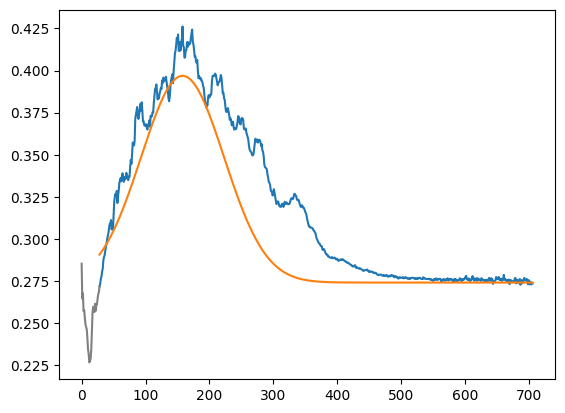

In [64]:
## remove me pls


inner_radius = resized_rtp.width
mean = np.mean(resized_rtp.frame(start_frame - 1))
for f in range(start_frame, resized_rtp.number_of_frames - 1):
    for r in range(np.argmax(resized_rtp.frame(f)), -1, -1):
        if resized_rtp.frame(f)[r] >= mean >= resized_rtp.frame(f)[r - 1]:
            inner_radius = min(inner_radius, r)
            break

# frame_of_max_intensity
plt.plot(np.arange(inner_radius, resized_rtp.width),
         resized_rtp.frame(np.argmax(np.max(resized_rtp, axis=1)))[inner_radius:])
plt.plot(np.arange(0, inner_radius + 1), resized_rtp.frame(np.argmax(np.max(resized_rtp, axis=1)))[:inner_radius + 1],
         color='grey')

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = resized_rtp.frame(np.argmax(np.max(resized_rtp, axis=1)))
(mu, sigma) = norm.fit(data)

mu = np.argmax(data)
sigma = (mu - inner_radius) / 2
# sigma = np.var()
print(mu, sigma)


def normal_dist(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1 / 2 * ((x - mu) / sigma) ** 2)


plt.plot(np.arange(inner_radius, resized_rtp.width),
         20 * normal_dist(np.arange(inner_radius, resized_rtp.width), mu, sigma) + mean)

plt.show()